In [23]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()
using OffsetArrays

In [18]:
nsamples = 10^3
R = 1//4
n = 16*4
@show n
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
rng = MersenneTwister(4)
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
B, indep = findbasis_slow(H)
B = BitMatrix(B)
BB = augment_basis(B)
sources = [bitrand(MersenneTwister(3*nsamples + k), n) for k in 1:nsamples];
# c = bitmult_fast(BB, idx_ref); # closest codeword

n = 64


In [19]:
h = [zeros(Int, size(B,1)+1) for _ in sources]
(m1, m2), (c1, c2) = exact_wef2(B, sources, h=h);

Exact WEF for 2 closest CWs 100%|███████████████████████| Time: 0:00:01


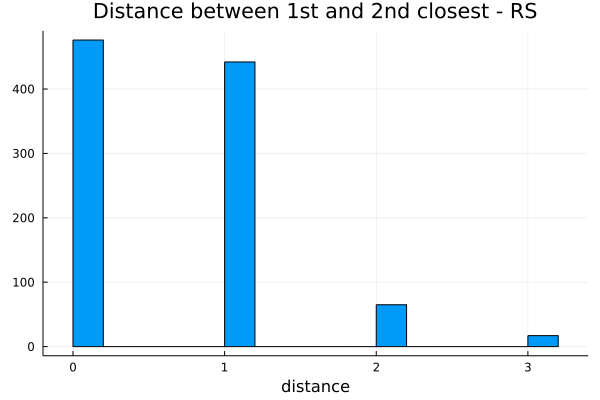

In [26]:
histogram((m2 .- m1) .* n, label="", title="Distance between 1st and 2nd closest - RS", xlabel="distance")

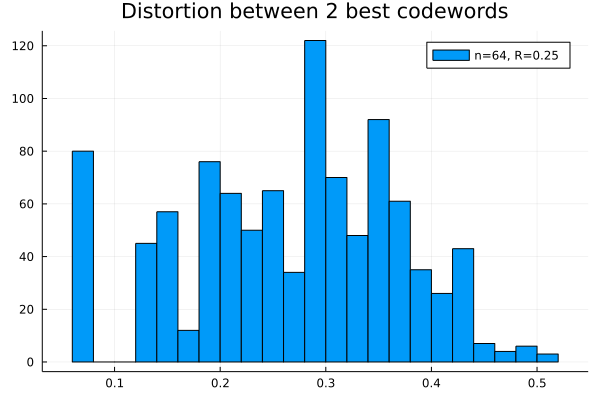

In [20]:
dd = [hamming(x1, x2)/n for (x1,x2) in zip(bitmult_fast.((BB,), c1), bitmult_fast.((BB,), c2))]
histogram(dd, bins=30, label="n=$n, R=$(float(R))", title="Distortion between 2 best codewords")

In [24]:
maxdistortions = 14/n:1/n:28/n
ncodewords = [[ncw(h[j], maxdistortion) for maxdistortion in maxdistortions] for j in 1:nsamples]
maxdistances = 10:2:n
X = [zeros(nsamples) for _ in maxdistances]
@telegram "Cluster exploration 2 - RSB" begin
    @showprogress for (k, maxdistance) in enumerate(maxdistances)
    #     println("Distance $k of ", length(maxdistances))
        @threads for j in 1:nsamples
            X[k][j] = two_cw_in_same_cc(B, maxdistortions, maxdistance, c1[j], c2[j], sources[j], 
                ncodewords=ncodewords[j], showprogress=false)
        end   
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:18


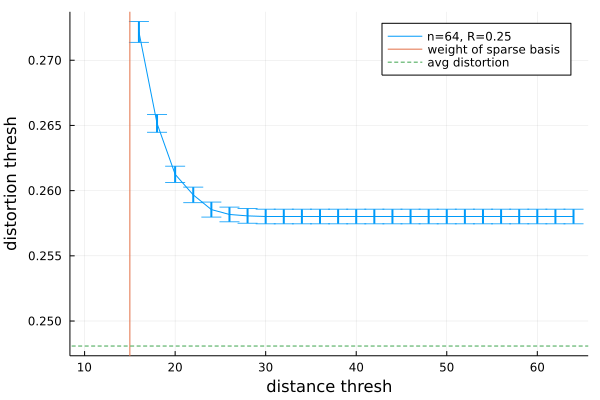

In [25]:
X_avg = [mean(x) for x in X]
X_std = [std(x)/sqrt(length(x)) for x in X]
pl = plot(maxdistances, X_avg, yerr=X_std, xlabel="distance thresh", ylabel="distortion thresh",
    label="n=$n, R=$(float(R))", msw=2, ms=10, msc=:auto)
_, w = lightest_basis(BB, n)
pl2 = deepcopy(pl)
vline!(pl2, [w], label="weight of sparse basis")
hline!(pl2, [mean(m1)], label="avg distortion", ls=:dash)

In [29]:
(X_avg[end] - mean(m1)) * n

0.636000000000001

In [239]:
mean(m1)

0.241265625

In [228]:
XX = [replace(xx, Inf => 0.4) for xx in X]
pl2 = deepcopy(pl)
for (k, maxdistance) in enumerate(maxdistances)
    scatter!(pl2, repeat([maxdistance], nsamples), XX[k] .+ 1e-4*randn(nsamples), c=:black, ms=1, label="")
end
plot!(pl2, size=(900,800), title="Smallest distortion at which the 2 cws are in the same cc. 0.4≡inf", 
    margins=5Plots.mm, dpi=300)

# Compare histograms as n scales

In [9]:
function two_cc_distances(n, R, nsamples; 
        bins=30, kw...)
    m = round(Int, n*(1-R))
    f3 = 1-3R
    Λ = [0,1-f3,f3]
    K = [0, 0, 1]
    nedges = 3m 
    rng = MersenneTwister(4)
    H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
    B, indep = findbasis_slow(H)
    B = BitMatrix(B)
    BB = augment_basis(B)
    sources = [bitrand(MersenneTwister(3*nsamples + k), n) for k in 1:nsamples]
    h = [zeros(Int, size(B,1)+1) for _ in sources]
    (m1, m2), (c1, c2) = exact_wef2(B, sources, h=h)
    dd = [hamming(x1, x2)/n for (x1,x2) in zip(bitmult_fast.((BB,), c1), bitmult_fast.((BB,), c2))]
end

two_cc_distances (generic function with 1 method)

In [ ]:
ns = 16 .* (4:6)
nsamples = 5*10^3
R = 1//4
dds = [Float64[] for nn in ns]
for (i,n) in enumerate(ns)
    dds[i] = two_cc_distances(n, R, nsamples)
end

Exact WEF for 2 closest CWs 100%|███████████████████████| Time: 0:00:09
Exact WEF for 2 closest CWs 100%|███████████████████████| Time: 0:02:39
Exact WEF for 2 closest CWs  30%|███████                |  ETA: 0:31:35

In [ ]:
using ColorSchemes
cg = cgrad(:matter, length(ns)+2, categorical=true)
styles = [:solid, :dash, :dot]
h = plot()
for (i,n) in enumerate(ns)
    histogram!(h, dds[i], bins=25, normalize=:pdf, label="n=$n, R=$(float(R))", st=:stephist, 
        c=cg[i+2], lw=3, ls=styles[i])
end
plot(h, title="Distortion between 2 best codewords", xlabel="dist", ylabel="counts (normalized)")

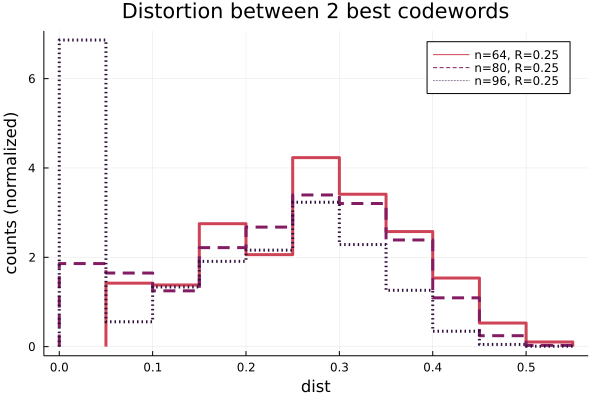

In [14]:
using ColorSchemes
cg = cgrad(:matter, length(ns)+2, categorical=true)
styles = [:solid, :dash, :dot]
h = plot()
for (i,n) in enumerate(ns)
    histogram!(h, dds[i], bins=10, normalize=:pdf, label="n=$n, R=$(float(R))", st=:stephist, 
        c=cg[i+2], lw=3, ls=styles[i])
end
plot(h, title="Distortion between 2 best codewords", xlabel="dist", ylabel="counts (normalized)")

In [121]:
h = [zeros(Int, size(B,1)+1) for _ in sources]
(m1, m2), (c1, c2) = exact_wef2(B, sources, h=h);

Exact WEF for 2 CWs100%|████████████████████████████████| Time: 0:00:02


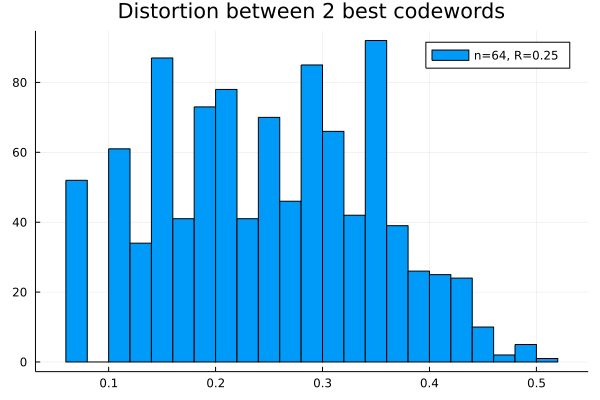

In [122]:
dd = [hamming(x1, x2)/n for (x1,x2) in zip(bitmult_fast.((BB,), c1), bitmult_fast.((BB,), c2))]
histogram(dd, bins=30, label="n=$n, R=$(float(R))", title="Distortion between 2 best codewords")

In [164]:
# store independent variables of codewords with distortion smaller than `maxdistortion`
function codeword_graph(B, s::BitVector, maxdistortion::Int, ref::Integer;
    y = BitVector(undef, size(B,1)), x = BitVector(undef, size(B,2)))
    BB = augment_basis(B)
    n, k = size(B)
    idx_ref = -1
    for i in 0:2^k-1
        i==ref && (idx_ref = length(c)+1)
        x.chunks[1] = i 
        bitmult_fast!(y, BB, x)
        d = distortion(y, s)
        d <= maxdistortion && push!(c, i)
        (d > maxdistortion && i==ref) && error("Reference codeword doesn't belong to the graph")
    end
    @assert c[idx_ref] == ref "c[idx_ref]=$(c[idx_ref]). ref=$ref"
    c, idx_ref
end

codeword_graph (generic function with 1 method)

In [4]:
# connected component on the graph starting from `ref`. 
# two nodes are neighbors if at distance <= maxdistance
function connected_component(c::Vector{Int}, idx_ref::Int, maxdistance::Int, B;
        y = BitVector(undef, size(B,1)), x = BitVector(undef, size(B,2)),
        z = BitVector(undef, size(B,1)), t = BitVector(undef, size(B,2)))
    n, k = size(B)
    r = 64 * ( floor(Int, n/64) + 1 )
    # extend B so that #rows is a multiple of 64 => easier for multiplication
    BB = [B; falses(r-n, k)]
    visited = falses(length(c))
    Q = [idx_ref]
    prog = ProgressMeter.ProgressUnknown()
    while !isempty(Q)
        w = popfirst!(Q)
        visited[w] == true && continue
        visited[w] = true
        t.chunks[1] = c[w]
        bitmult_fast!(z, BB, t)
        for i in eachindex(c)
            visited[i] && continue
            x.chunks[1] = c[i]
            bitmult_fast!(y, BB, x)
            d = distortion(y, z)
            d <= maxdistance && push!(Q, i)
        end
        ProgressMeter.next!(prog, showvalues=[(:nvisited, "$(sum(visited))/$(length(c))")])
    end
    visited
end

connected_component (generic function with 1 method)

### The two closest codewords

In [16]:
R = 1//4
n = 16*6
@show n
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
rng = MersenneTwister(2)
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
i = findfirst(isequal(2), vec(sum(H, dims=1)))
a = findfirst(!isequal(0), H[:,i])
H = H[[1:a-1; a+1:end], :]
B, indep = findbasis(H)
B = BitMatrix(B)
rtrue = size(B,2) // size(B,1)
# @assert R == rtrue
nsources = 20
sources = [bitrand(MersenneTwister(k+100), n) for k in 1:nsources]
h0 = zeros(Int, size(B,1)+1)
h = [zeros(Int, size(B,1)+1) for _ in sources]
m, idx = exact_wef2(B, sources, h0=h0, h=h)

n = 96


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


(([0.21875, 0.22916666666666666, 0.19791666666666666, 0.22916666666666666, 0.21875, 0.25, 0.23958333333333334, 0.2604166666666667, 0.2708333333333333, 0.25, 0.2604166666666667, 0.23958333333333334, 0.2604166666666667, 0.2708333333333333, 0.25, 0.23958333333333334, 0.25, 0.25, 0.21875, 0.23958333333333334], [0.22916666666666666, 0.23958333333333334, 0.22916666666666666, 0.23958333333333334, 0.22916666666666666, 0.25, 0.23958333333333334, 0.2604166666666667, 0.28125, 0.25, 0.2708333333333333, 0.25, 0.2604166666666667, 0.2708333333333333, 0.25, 0.23958333333333334, 0.25, 0.2604166666666667, 0.22916666666666666, 0.23958333333333334]), ([2673422, 27271393, 24153139, 32476641, 1565715, 18140390, 11307355, 740186, 2391182, 13999558, 33305386, 24282242, 19762630, 17770700, 25609478, 1810025, 9193761, 16810657, 22255092, 14257532], [592414, 27271329, 24153143, 27777505, 1565723, 18140742, 28084728, 2329929, 1865493, 16882886, 21605146, 7512106, 24022470, 18577636, 30859554, 4690217, 21973281, 1

In [17]:
[m[1] m[2]] * n

20×2 Matrix{Float64}:
 21.0  22.0
 22.0  23.0
 19.0  22.0
 22.0  23.0
 21.0  22.0
 24.0  24.0
 23.0  23.0
 25.0  25.0
 26.0  27.0
 24.0  24.0
 25.0  26.0
 23.0  24.0
 25.0  25.0
 26.0  26.0
 24.0  24.0
 23.0  23.0
 24.0  24.0
 24.0  25.0
 21.0  22.0
 23.0  23.0

In [176]:
β = 1
maxdistortion = distortion_thresh(h[1], β, 0.9)
c1, idx_ref1 = codeword_graph(B, sources[1], maxdistortion, idx[1][1])
c2, idx_ref2 = codeword_graph(B, sources[1], maxdistortion, idx[2][1])
maxsizes1 = length(c1)
maxsizes2 = length(c2)
maxdistances = 1:16
same_cc = 0
for j in eachindex(maxdistances)
    d = maxdistances[j]
    cc1 = findall(connected_component(c1, idx_ref1, d, B))
    if idx_ref2 ∈ cc1
        same_cc = maxdistances[j]
        break
    end
end

In [177]:
same_cc

10

In [ ]:
nsamples = 20
sources = [bitrand(MersenneTwister(k), n) for k in 1:nsamples]
betas = [0.6, 0.8, 1, 2]
same_cc_hist = [zeros(nsamples) for _ in betas]
maxdistances = 1:16
R = 1//4
n = 16*4
@show n
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
rng = MersenneTwister(3)
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
i = findfirst(isequal(2), vec(sum(H, dims=1)))
a = findfirst(!isequal(0), H[:,i])
H = H[[1:a-1; a+1:end], :]
B, indep = findbasis(H)
B = BitMatrix(B)
h = [zeros(Int, size(B,1)+1) for _ in sources]
m, idx = exact_wef2(B, sources, h=h)
for (q,β) in enumerate(betas)
    @threads for k in 1:nsamples
        maxdistortion = distortion_thresh(h[k], β, 0.95)
        c1, idx_ref1 = codeword_graph(B, sources[k], maxdistortion, idx[1][k])
        c2, idx_ref2 = codeword_graph(B, sources[k], maxdistortion, idx[2][k])
        maxsizes1 = length(c1)
        maxsizes2 = length(c2)
        same_cc = 0
        for j in eachindex(maxdistances)
            d = maxdistances[j]
            cc1 = findall(connected_component(c1, idx_ref1, d, B))
            if idx_ref2 ∈ cc1
                same_cc_hist[q][k] = maxdistances[j]
                break
            end
        end
    end
end

In [ ]:
@telegram "cluster expl 2"

In [ ]:
dist = zeros(nsamples)
x = falses(size(B,2))
w = falses(size(B,2))
y = falses(n); z = falses(n)
for i in 1:nsamples
    x.chunks[1] = idx[1][i]
    w.chunks[1] = idx[2][i]
    bitmult_fast!(y, B, x)
    bitmult_fast!(z, B, w)
    dist[i] = distortion(y, z) / n
end
histogram(dist, xlabel="Distance between 2 closest codewords", label="", bins=10)

In [ ]:
pl = plot()
styles = [:dash, :solid, :dot]
for (q,β) in enumerate(betas)
    histogram!(pl, same_cc_hist[q], st=:stephist, label="β=$β", ls=styles[q], lw=2,
        bins=10)
end
plot(pl, xlabel="distance threshold")

In [199]:
using IJuliaBell
@bell sleep(1)

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

## Weight with $\beta$

In [14]:
R = 1//4
n = 16*5
@show n
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K))
i = findfirst(isequal(2), vec(sum(H, dims=1)))
a = findfirst(!isequal(0), H[:,i])
H = H[[1:a-1; a+1:end], :]
B, indep = findbasis(H)
B = BitMatrix(B)
rtrue = size(B,2) // size(B,1)
# @assert R == rtrue
rng = MersenneTwister(0)
s = bitrand(rng, n);
argmins = [0]
_, h, mindist = exact_wef(B, [s], argmins=argmins)
ref = argmins[1]
# maxdistortion = distortion_thresh(h[1], β)
# c, idx_ref = codeword_graph(B, s, maxdistortion, ref)

n = 80


1608333

In [15]:
mindist

1-element Vector{Float64}:
 0.225

In [6]:
sum(B, dims=1)

1×21 Matrix{Int64}:
 5  12  15  3  17  15  15  18  16  17  …  12  16  16  22  21  19  20  23  26

In [26]:
betas = 0.8:0.1:1.6
maxdistances = 1:25
sizes = [zeros(Int, length(maxdistances)) for _ in betas]
maxsizes = zeros(Int, length(betas))
cg = cgrad(:jet, length(betas), categorical=true)
markers =  [:circle, :rect, :star5, :diamond, :hexagon, :cross, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x]
cc = [ [Int[] for _ in maxdistances] for _ in betas ]
@time begin
for i in eachindex(betas)
    β = betas[i]
    argmins = [0]
    _, h, mindist = exact_wef(BitMatrix(B), [s], argmins=argmins)
    ref = argmins[1]
    maxdistortion = distortion_thresh(h[1], β, 0.9)
    c, idx_ref = codeword_graph(BitMatrix(B), s, maxdistortion, ref)
    maxsizes[i] = length(c)
    for j in eachindex(maxdistances)
        d = maxdistances[j]
        cc[i][j] = findall(connected_component(c, idx_ref, d, BitMatrix(B)))
        if length(cc[i][j])==length(c)
            cc[i][j+1:end] = [c for _ in j+1:length(cc[i])] 
            break
        end
    end
    sizes[i] = [length(ccc) for ccc in cc[i]]
end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress:  1047 	 Time: 0:00:00
  nvisited:  1047/1703

505.283685 seconds (3.78 M allocations: 279.436 MiB, 0.05% gc time, 0.01% compilation time)


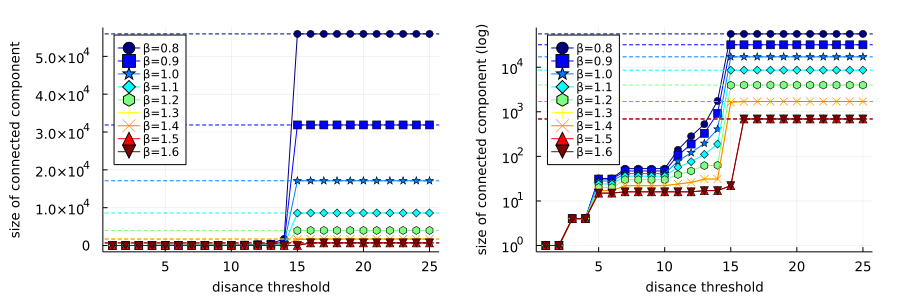

In [27]:
Plots.default(labelfontsize=9)
pl = plot()
for (i,β) in enumerate(betas)
    hline!(pl, [maxsizes[i]], ls=:dash, c=cg[i], label="")
    plot!(pl, maxdistances, sizes[i], label="β=$β", c=cg[i], m=markers[i])
end
p1 = plot(pl, legend=:topleft, xlabel="disance threshold", ylabel="size of connected component",
    size=(600,350))
p2 = plot(pl, legend=:topleft, xlabel="disance threshold", ylabel="size of connected component (log)",
    size=(600,350), yaxis=:log10)
plot(p1, p2, size=(900, 300), margin=5Plots.mm)

In [28]:
using IJuliaBell

@bell sleep(1)

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

In [673]:
distortion_thresh(h[1], 1.0, 0.5) / n

0.2875

In [408]:
betas = reverse( 1 ./ (0.1:0.1:2) )
Eavg = zeros(length(betas))
for (i,β) in enumerate(betas)
    p = [h[1][i]*exp(-β*i) for i in eachindex(h[1])]
    p ./= sum(p)
    Eavg[i] = (eachindex(p) .- 1)'p / n
end

In [410]:
[betas Eavg]

20×2 Matrix{Float64}:
  0.5       0.375217
  0.526316  0.368719
  0.555556  0.361574
  0.588235  0.353704
  0.625     0.345034
  0.666667  0.335498
  0.714286  0.325064
  0.769231  0.313763
  0.833333  0.30174
  0.909091  0.289309
  1.0       0.276989
  1.11111   0.265473
  1.25      0.255485
  1.42857   0.247565
  1.66667   0.241883
  2.0       0.238224
  2.5       0.236108
  3.33333   0.234991
  5.0       0.234482
 10.0       0.234376

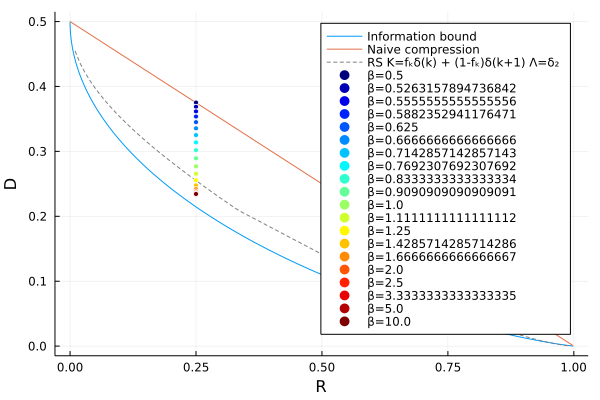

In [406]:
pp = plot_rdb()
cg = cgrad(:jet, length(betas), categorical=true)
for (i,β) in enumerate(betas)
    scatter!(pp, [R], [Eavg[i]], label="β=$β", ms=3, msc=:white, c=cg[i])
end
pp

In [478]:
sum(H, dims=1)

1×64 Matrix{Int64}:
 2  2  2  2  3  3  3  2  3  2  2  2  2  …  3  2  2  2  3  3  2  2  2  2  2  2

In [480]:
i = findfirst(isequal(2), vec(sum(H, dims=1)))
a = findfirst(!isequal(0), H[:,i])

27

In [579]:
function explore_cluster(R, n, maxdistances, nsources, β; 
        rng = MersenneTwister(0))
    m = round(Int, n*(1-R))
    f3 = 1-3R
    Λ = [0,1-f3,f3]
    K = [0, 0, 1]
    nedges = 3m 
    H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
#     i = findfirst(isequal(2), vec(sum(H, dims=1)))
#     a = findfirst(!isequal(0), H[:,i])
#     H = H[[1:a-1; a+1:end], :]
    B, indep = findbasis_slow(BitMatrix(H))
    rtrue = size(B,2) // size(B,1)
    @assert R == rtrue
    cc = Vector{Vector{Vector{Int64}}}(undef, nsources)
    @threads for i in 1:nsources
        Random.seed!(rng, i)
        s = bitrand(rng, n)
        argmins = [0]
        _, h, mindist = exact_wef(B, [s], argmins=argmins)
        ref = argmins[1]
        maxdistortion = distortion_thresh(h[1], β, 0.9)
        c, idx_ref = codeword_graph(B, s, maxdistortion, ref)
        cc[i] = [findall(connected_component(c, idx_ref, d, B)) for d in maxdistances]
    end
    cc
end

explore_cluster (generic function with 3 methods)

In [330]:
R = 1 // 4
n = 32*2

64

In [335]:
maxdistances = ceil.(Int, (0.00:0.01:0.13)*n)
nsources = 10
β = 0.5
cc = explore_cluster(R, n, maxdistances, nsources, β);

Progress:  38 	 Time: 0:00:00
  nvisited:  38/42463

In [423]:
maxdistances = 1:10

15-element Vector{Int64}:
 0
 1
 2
 2
 3
 4
 4
 5
 6
 6
 7
 8
 8
 9
 9

In [437]:
betas = [0, 0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
maxdistances = 1:11
sz_avg = [zeros(length(maxdistances)) for _ in betas]
sz_std = [zeros(length(maxdistances)) for _ in betas]
for (i,β) in enumerate(betas)
    cc = explore_cluster(R, n, maxdistances, nsources, β)
    sizes = [length.(ccc) for ccc in cc]
    sz_avg[i] = mean(sizes)
    sz_std[i] = std(sizes) ./ sqrt(nsources)
end

Progress:  247 	 Time: 0:00:00
Progress:  104 	 Time: 0:00:00
Progress:  113 	 Time: 0:00:00
Progress:  130 	 Time: 0:00:00
Progress:  129 	 Time: 0:00:00
  nvisited:  129/5040

In [438]:
pl = Plots.plot()
cg = cgrad(:matter, length(betas), categorical=true)
for (i,β) in enumerate(betas)
    plot!(pl, maxdistances, sz_avg[i], yerr=sz_std[i], xlabel="distance threshold", ylabel="size of connected component", 
        label="R=$(float(R)), n=$n, β=$β", legend=:topleft, m=:o, title="avg over $nsources sources",
        c = cg[i])
end

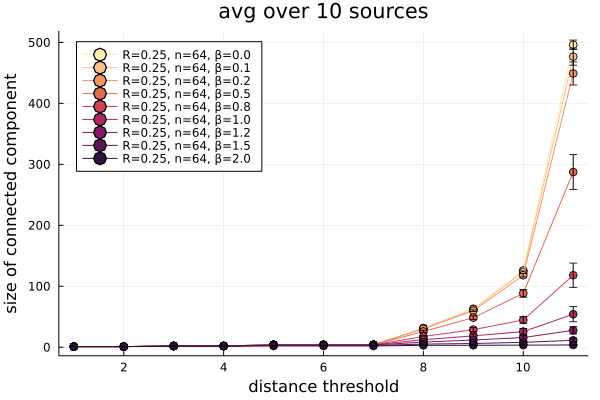

In [439]:
pl

In [336]:
sizes = [length.(ccc) for ccc in cc]
sizes_avg = mean(sizes)
sizes_std = std(sizes) ./ sqrt(nsources);

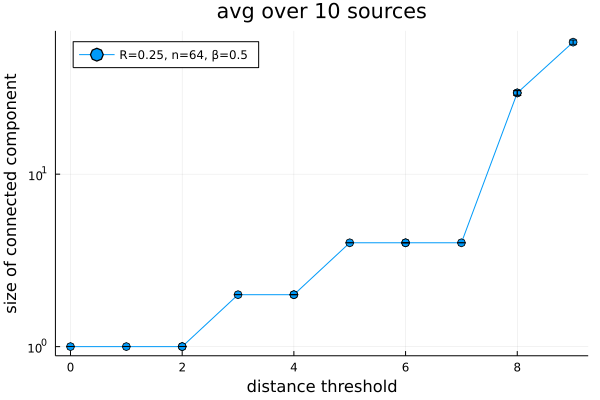

In [337]:
pl = plot(maxdistances, sizes_avg, yerr=sizes_std, xlabel="distance threshold", ylabel="size of connected component", 
    label="R=$(float(R)), n=$n, β=$β", legend=:topleft, m=:o, title="avg over $nsources sources",
    yaxis=:log10)

In [183]:
R2 = 6 // 32
n2 = 128
nsources2 = 10
maxdistances2 = ceil.(Int, (0.01:0.01:0.17)*n2)
cc2 = explore_cluster(R2, n2, maxdistances2, nsources);

Progress:  372 	 Time: 0:00:20
  nvisited:  372/358427

In [184]:
sizes2 = [length.(ccc) for ccc in cc2]
sizes2_avg = mean(sizes2)
sizes2_std = std(sizes2) ./ sqrt(nsources2);;

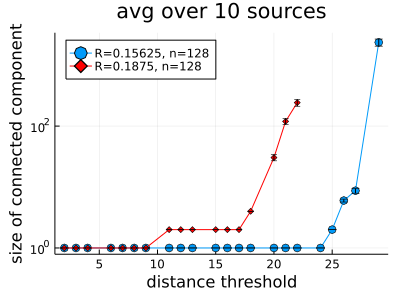

In [195]:
pl2 = plot!(deepcopy(pl), maxdistances2, sizes2_avg, yerr=sizes2_std, xlabel="distance threshold", 
    ylabel="size of connected component",
    label="R=$(float(R2)), n=$n2", legend=:topleft, m=:diamond, c=:red, yaxis=:log10, ms=3,
    size=(400,300))

In [51]:
function exact_wef_cluster(B, thresh::Real, s2, sources=BitVector[]; showprogress=true,
    y = BitVector(undef, size(B,1)),
    x = BitVector(undef, size(B,2)),
    h0 = zeros(Int, size(B,1)+1),
    h = [zeros(Int, size(B,1)+1) for _ in sources],
    mins = fill(size(B,1), length(sources)),
    argmins = fill(0, length(sources)))

    n, k = size(B)
    @assert all(x->length(x)==n, sources)
    @assert k < 64 "Adjust code for k larger than 64" 

    r = 64 * ( floor(Int, n/64) + 1)
    # extend B so that #rows is a multiple of 64 => easier for multiplication
    BB = [B; falses(r-n, k)]
    
    dt = showprogress ? 1.0 : Inf
    prog = ProgressMeter.Progress(2^k, dt=dt)
    for i in 0:2^k-1
        x.chunks[1] = i 
        bitmult_fast!(y, BB, x)
        d = hamming_weight(y)
        h0[d+1] += 1
        for (j,s) in enumerate(sources)
            d = distortion(y, s)
            if distortion(s, s2)/n < thresh
                h[j][d+1] += 1
                if d < mins[j]
                    mins[j] = d
                    argmins[j] = i
                end
            end
        end
        ProgressMeter.next!(prog)
    end
    h0, h, mins ./ n
end

exact_wef_cluster (generic function with 5 methods)

In [52]:
R = 5 // 32
n = 128
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
rng = MersenneTwister(0)
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
s = bitrand(rng, n)
B, indep = findbasis_slow(BitMatrix(H))
rtrue = size(B,2) // size(B,1)
@assert R == rtrue
argmins = [0]
_, _, mindist = exact_wef(B, [s], argmins=argmins)

([1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [0.3046875])

In [53]:
k = length(indep)
x = falses(k)
x.chunks[1] = argmins[1]
y = falses(n)
r = 64 * ( floor(Int, n/64) + 1)
BB = [B; falses(r-n, k)]
bitmult_fast!(y, BB, x)
@assert distortion(y, s) / n == mindist[1]

In [68]:
threshs = 0.1:0.1:1
hs = []
for (i, thresh) in enumerate(threshs)
    h0, h, mins = exact_wef_cluster(B, thresh, s, [y], showprogress=false)
    push!(hs, h[1])
end

┌ Warning: WEF vector is empty
└ @ Main /home/crotti/sourcecoding/code/exact_enum.jl:155
┌ Warning: WEF vector is empty
└ @ Main /home/crotti/sourcecoding/code/exact_enum.jl:155
┌ Warning: WEF vector is empty
└ @ Main /home/crotti/sourcecoding/code/exact_enum.jl:155


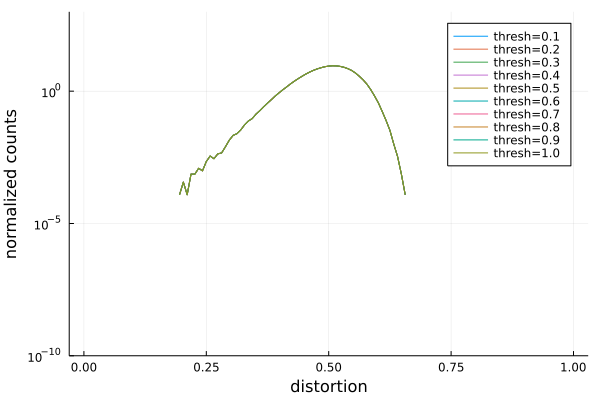

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero valu

In [69]:
pl = Plots.plot()
for (i, thresh) in enumerate(threshs)
    plot_wef!(pl, hs[i], plotmin=false, label="thresh=$thresh",
            seriestype=:line, yaxis=(:log10, (1e-10,10^3)), titlefontsize=9, ms=1.5, msw=0)
end
pl